In [ ]:
#!pip install dgl==0.9.1 dglgo -f https://data.dgl.ai/wheels/repo.html -q

In [192]:
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import networkx as nx
import requests
import numpy as np
import pandas as pd

import torch
from sklearn.metrics import balanced_accuracy_score
import torch.nn as nn
from tqdm.notebook import trange
from sklearn.manifold import TSNE
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

import dgl
from dgl.data import CoraGraphDataset
from dgl import function as fn
from dgl.nn import SAGEConv

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [193]:
feat = pd.read_csv('node_feat.txt', sep=' ', names=np.arange(32)).values
train_edges = pd.read_csv('train_edges.txt', sep=' ', names=[0, 1]).values
unlabeled_edges = pd.read_csv('unlabeled_edges.txt', sep=' ', names=[0, 1]).values

In [223]:
assert len(set(np.unique(unlabeled_edges.flatten())).difference(set(np.unique(train_edges.flatten())))) == 0
assert feat.shape[0] == np.unique(train_edges.flatten()).shape[0]

train_edges.shape, unlabeled_edges.shape, feat.shape

((14322, 2), (44014, 2), torch.Size([12588, 32]))

# Negative Sampling

In [196]:
def negative_sampling(train_pos):
    train_nodes = set()
    for u, v in train_pos:
      train_nodes.add(u)
      train_nodes.add(v)
    train_nodes = list(train_nodes)
    negative_train = []
    all_edges = set([(u, v) for u, v in train_pos])
    for u, v in train_pos:
      sn = np.random.choice(train_nodes)
      while sn == u or sn == v or (u, sn) in all_edges or (sn, u) in all_edges:
        sn = np.random.choice(train_nodes)
      negative_train.append((u, sn))
    
    return negative_train

In [197]:
train_neg_edges = negative_sampling(train_edges)

In [198]:
N = train_edges.shape[0]
y_train = np.concatenate([np.ones(N), np.zeros(N)])
X_train = np.concatenate((train_edges, train_neg_edges), axis=0)

random_idx = np.random.choice(np.arange(y_train.shape[0]), y_train.shape[0],replace=False)
X_train, y_train = X_train[random_idx], y_train[random_idx]

X_train.shape, y_train.shape

((28644, 2), (28644,))

In [ ]:
unlabeled_edges_ = [(u, v) for u, v in unlabeled_edges]
#assert np.sum([(E in unlabeled_edges_) for E in train_neg_edges]) == 0

# Autoencoder

In [200]:
G = nx.Graph()
G.add_nodes_from(np.unique(train_edges.flatten()))
G.add_edges_from(train_edges)

feat = torch.from_numpy(feat).double()
y_train = torch.Tensor(y_train)

G_dgl = dgl.from_networkx(G)

adj = G_dgl.adj().to_dense()
G_dgl.ndata['feat'] = feat

In [201]:
class GCNMessagePassingLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.dense = nn.Linear(in_dim, out_dim)
    def forward(self, graph, h):
        W = self.dense.weight.T.double()
        b = self.dense.bias.double()

        with graph.local_scope():
            graph = graph.add_self_loop()
            in_degrees = graph.in_degrees()
            graph.ndata['h'] = (h @ W + b) / torch.sqrt(torch.abs(in_degrees)).reshape(-1, 1)
            
            msg = fn.copy_src(src='h', out='m')
            rdc = fn.sum(msg='m', out='h')

            graph.update_all(msg, rdc)
            H = graph.ndata['h'] / torch.sqrt(torch.abs(in_degrees)).reshape(-1, 1)

        return H


class GCNMessagePassing(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.conv1 = GCNMessagePassingLayer(in_dim, hid_dim)
        self.activation = nn.ReLU()
        self.conv2 = GCNMessagePassingLayer(hid_dim, out_dim)

    def forward(self, graph, feat):
        hidden = self.activation(self.conv1(graph, feat))
        out = self.conv2(graph, hidden)

        return out


class HadamartProductDecoder(nn.Module):
    def __init__(self, in_dim, hid_dim):
        super().__init__()
        self.MLP = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, 1),
            nn.Sigmoid()
        ).double()

    def forward(self, encoded_values, edges):
        hadamard_embeddings = self.hadamard_operator_(encoded_values, edges)

        out = self.MLP(hadamard_embeddings)
        return out
    
    def hadamard_operator_(self, embeddings, edges):
        edge_embeddings = embeddings[edges[:,0]] * embeddings[edges[:,1]]

        return edge_embeddings.double()

In [202]:
class GAE(torch.nn.Module):
	def __init__(self):
		super().__init__()

		n_nodes = 12588
		n_edges = 14322

		encoder_hidden = 16
		encoder_out = 8
		decoder_hidden = 8
		
		self.encoder = GCNMessagePassing(in_dim=32, hid_dim=encoder_hidden, out_dim=encoder_out)
		self.decoder = HadamartProductDecoder(in_dim=encoder_out, hid_dim=decoder_hidden)

	def forward(self, G, feat, edges):
		encoded = self.encoder(G, feat)
		decoded = self.decoder(encoded, edges)
		
		return decoded

In [203]:
model = GAE()
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 0.01, weight_decay = 1e-8)

In [204]:
n_epochs = 400
log = []
acc = []

for i in trange(n_epochs):

    class_proba = model(G_dgl, feat, X_train)
    loss = criterion(class_proba.flatten().double(), y_train.double())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    log.append(loss.item())

    with torch.no_grad():
        accuracy = torch.sum((class_proba.flatten() > 0.5).int() == y_train) / y_train.shape[0]
        acc.append(accuracy)

  0%|          | 0/400 [00:00<?, ?it/s]

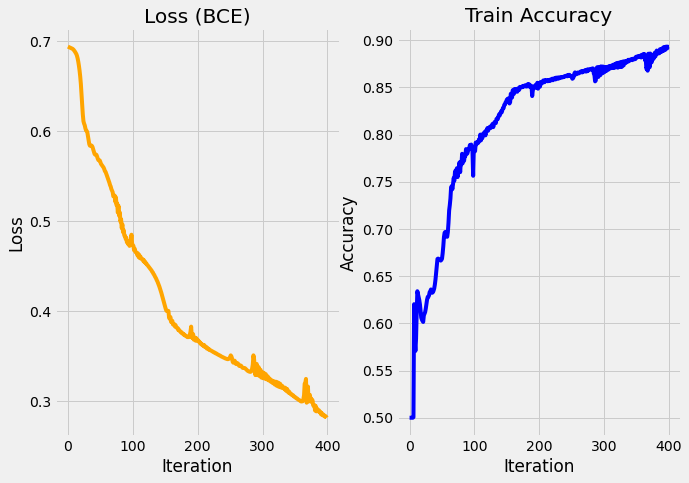

In [205]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

ax.flatten()[0].plot(log, color='orange')
ax.flatten()[0].set(title='Loss (BCE)', xlabel='Iteration', ylabel='Loss')

ax.flatten()[1].plot(acc, color='blue')
ax.flatten()[1].set(title='Train Accuracy', xlabel='Iteration', ylabel='Accuracy')

plt.show();

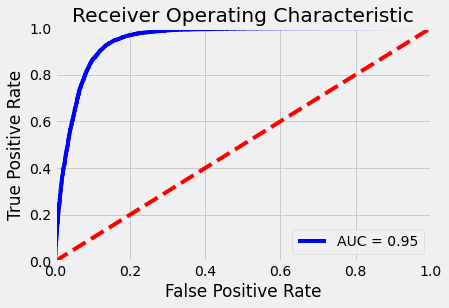

In [206]:
with torch.no_grad():
    fpr, tpr, threshold = roc_curve(y_train, class_proba.flatten())
    roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Validation

In [161]:
from sklearn.model_selection import train_test_split

In [162]:
feat = pd.read_csv('node_feat.txt', sep=' ', names=np.arange(32)).values
edges = pd.read_csv('train_edges.txt', sep=' ', names=[0, 1]).values
neg_edges = negative_sampling(train_edges)

In [163]:
N = edges.shape[0]
y = np.concatenate([np.ones(N), np.zeros(N)])
X = np.concatenate((edges, neg_edges), axis=0)

random_idx = np.random.choice(np.arange(y.shape[0]), y.shape[0], replace=False)
X, y = X[random_idx], y[random_idx]

In [164]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=12, stratify=y)

In [165]:
val_nodes = set([u for u, v in X_val] + [v for u, v in X_val])
train_nodes = set([u for u, v in X_train] + [v for u, v in X_train])

val_only_nodes = val_nodes.difference(train_nodes)
val_to_keep = []

for i in range(y_val.shape[0]):
    u, v = X_val[i]
    if (u not in val_only_nodes) and (v not in val_only_nodes):
        val_to_keep.append(i)

mask_keep = np.zeros(X_val.shape[0], dtype=bool)
mask_keep[val_to_keep] = True

X_train = np.concatenate([X_train, X_val[~mask_keep]], axis=0)
y_train = np.concatenate([y_train, y_val[~mask_keep]])

X_val, y_val = X_val[val_to_keep], y_val[val_to_keep]

In [177]:
G = nx.Graph()
G.add_nodes_from(np.unique(X_train.flatten()))
G.add_edges_from(X_train)

feat = torch.from_numpy(feat).double()
y_train = torch.Tensor(y_train)
y_val = torch.Tensor(y_val)

G_dgl = dgl.from_networkx(G)

adj = G_dgl.adj().to_dense()
G_dgl.ndata['feat'] = feat

In [171]:
model_val = GAE()
criterion = nn.BCELoss()
optimizer = Adam(model_val.parameters(), lr = 0.01, weight_decay = 1e-8)

n_epochs = 400
log = []
val_log = []
acc = []
val_acc = []

for i in trange(n_epochs):

    class_proba = model_val(G_dgl, feat, X_train)
    loss = criterion(class_proba.flatten().double(), y_train.double())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    log.append(loss.item())

    with torch.no_grad():
        accuracy = torch.sum((class_proba.flatten() > 0.5).int() == y_train) / y_train.shape[0]
        acc.append(accuracy)

        val_proba = model_val(G_dgl, feat, X_val)
        val_loss = criterion(val_proba.flatten().double(), y_val.double())
        val_log.append(val_loss.item())

        accuracy = torch.sum((val_proba.flatten() > 0.5).int() == y_val) / y_val.shape[0]
        val_acc.append(accuracy)

  0%|          | 0/400 [00:00<?, ?it/s]

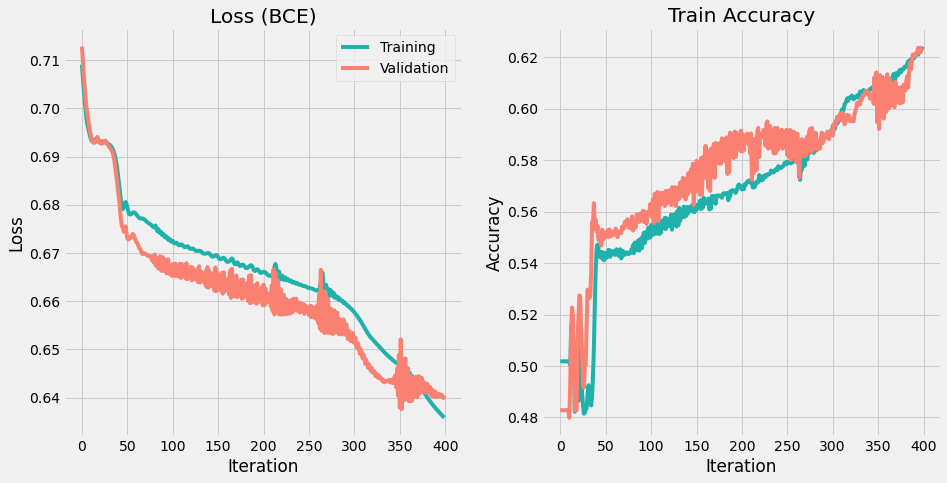

In [172]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

ax.flatten()[0].plot(np.minimum(log, 1.5), color='lightseagreen', label='Training')
ax.flatten()[0].plot(np.minimum(val_log, 1.5), color='salmon', label='Validation')
ax.flatten()[0].set(title='Loss (BCE)', xlabel='Iteration', ylabel='Loss')
ax.flatten()[0].legend()

ax.flatten()[1].plot(acc, color='lightseagreen', label='Training')
ax.flatten()[1].plot(val_acc, color='salmon', label='Validation')
ax.flatten()[1].set(title='Train Accuracy', xlabel='Iteration', ylabel='Accuracy')
ax.flatten()[0].legend()

plt.show();

In [208]:
with torch.no_grad():
    #class_proba = model_val(G_dgl, feat, unlabeled_edges)
    class_proba = model(G_dgl, feat, unlabeled_edges)
    predictions = np.array((class_proba.flatten() > 0.5).int())

np.unique(predictions, return_counts=True)

(array([0, 1], dtype=int32), array([24015, 19999]))

In [209]:
with open('predictions.txt', 'w') as file:
    out_iterator = [i+'\n' for i in predictions.astype(str)]
    file.writelines(out_iterator)

# Experiments

In [ ]:
def neighbor_weighted_l2_operator(G, embeddings, edges):

    def get_mean_embedding(node):
        neighbors = list(G.predecessors(node)) + [node]
        return embeddings[neighbors,:].mean(axis=0)
    
    edge_embeddings = torch.tensor([torch.square(get_mean_embedding(u) - get_mean_embedding(v)) for u, v in edges])

    return edge_embeddings